# AI

In [1]:
import osmnx as ox
import matplotlib.pyplot as plt
import contextily as ctx
import networkx as nx


In [2]:
# Nome da cidade
cidade = "São Carlos, São Paulo, Brasil"

# Baixa o grafo das ruas para transporte por carro (modo drive)
G = ox.graph_from_place(cidade, network_type='drive')
ox.save_graphml(G, filepath="sao_carlos.graphml")


Número de nós: 9042
Número de arestas: 22340


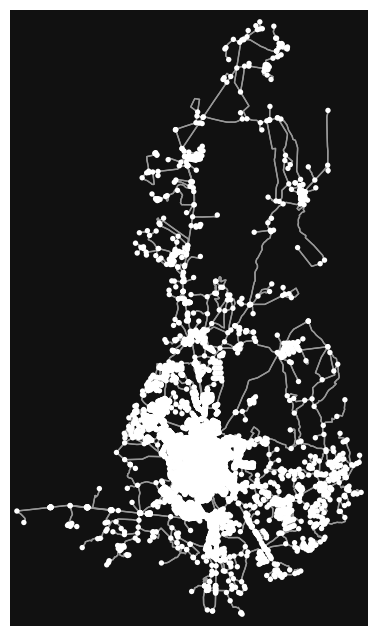

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [8]:
G = ox.load_graphml("sao_carlos.graphml")

# Mostra informações do grafo
print(f"Número de nós: {len(G.nodes)}")
print(f"Número de arestas: {len(G.edges)}")

# Desenha o grafo
ox.plot_graph(G)


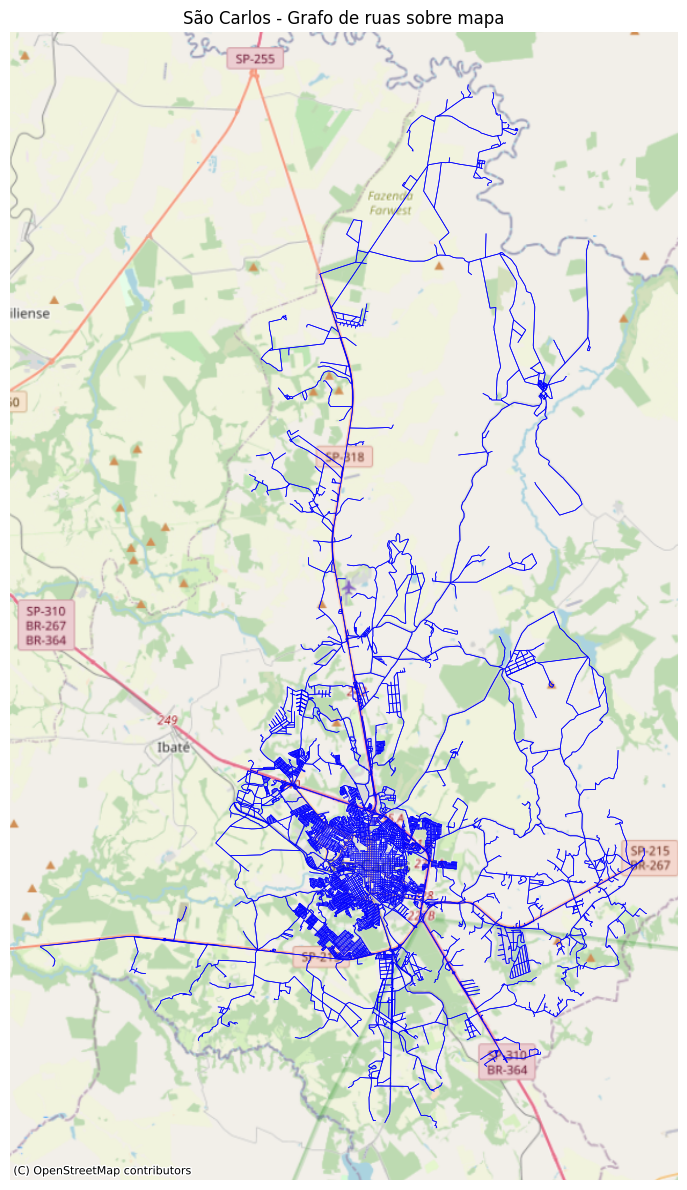

In [9]:
nodes, edges = ox.graph_to_gdfs(G)

# Plota com mapa de fundo
fig, ax = plt.subplots(figsize=(12, 12))
edges.plot(ax=ax, linewidth=0.5, edgecolor="blue")
ctx.add_basemap(ax, crs=edges.crs, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()
plt.title("São Carlos - Grafo de ruas sobre mapa")
plt.tight_layout()
plt.savefig("sao_carlos_mapa.png", dpi=300)

plt.show()

In [ ]:
# Definindo a DATABASE dos hospitais


In [ ]:
# Vamos implementar as buscas
G = nx.read_graphml('sao_carlos.graphml')




MultiDiGraph with 9042 nodes and 22340 edges


NameError: name 'no_atual' is not defined